# Experiment tracking with [WandB](https://wandb.ai/)

[Weights and Biases](https://wandb.ai/) is an experment tracking tool that is great for its lightweight logging utilities. 

## Setup WandB
After initializing a run, we can track all the Damuta model specs to the wandb run config. Specs you may want to track are: datasets (as [artifacts](https://docs.wandb.ai/guides/artifacts)), model parameters (as a [config](https://docs.wandb.ai/guides/track/config)) or metrics and plots (as [logged data](https://docs.wandb.ai/guides/track/log))

**Warning**: Private data may not be appropriate to upload to WandB. See [storage FAQ](https://docs.wandb.ai/guides/artifacts/artifacts-faqs#where-are-artifact-files-stored) to ensure that WandB policies are compliant with your data-handling requirements.

The wandb dashboard associated with this notebook is available [here](https://wandb.ai/harrig12/damuta-docs_examples)

In [ ]:
import wandb
import pandas as pd
import damuta as da

In [2]:
# Initialize wandb run
run = wandb.init()

# Read in example pcawg data
counts = pd.read_csv('example_data/pcawg_counts.csv', index_col=0)
annotation = pd.read_csv('example_data/pcawg_cancer_types.csv', index_col=0)

# Log data as an artifact
artifact = wandb.Artifact('pcawg', type='dataset')
artifact.add(wandb.Table(data=counts), 'counts')
artifact.add(wandb.Table(data=annotation), 'annotation')
wandb.log_artifact(artifact)

# Create input DataSet
pcawg = da.DataSet(counts,annotation)

wandb: Currently logged in as: harrig12 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# Instantiate the model
model = da.models.Lda(pcawg, n_sigs = 20)

# Log model parameters, and fitting parameters to wandb
run.config.update({"n_sigs": model.n_sigs, "init_strategy": model.init_strategy,
                   "opt_method": model.opt_method, "seed": model.seed,
                   })

# Fit the model
model.fit(n=1000)

Finished [100%]: Average Loss = 4.9086e+07


If necessary, The wandb config can also be updated after `model.fit()` has been called. 

Now that we have fit the model, we can plot the ELBO, and log the final value with wandb.

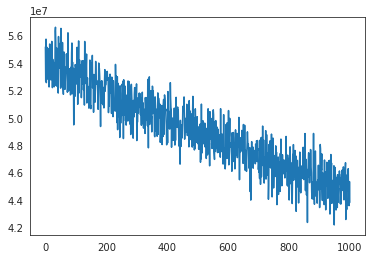

In [4]:
import matplotlib.pyplot as plt
plt.plot(model.approx.hist)

In [5]:
wandb.log({"final ELBO value": model.approx.hist[-1]})
wandb.finish()

final ELBO value,43818341.95693
_runtime,657
_timestamp,1648576865
_step,0


final ELBO value,▁
_runtime,▁
_timestamp,▁
_step,▁


## Callbacks 

We can also make use of callbacks to log this value over the course of the fitting procedure. This way, our ELBO plot will be automatically generated by wandb, and will live-update on the wandb dashboard as we fit the model. Let 's create a new run with a callback to demonstrate this. 

In [9]:
from damuta.callbacks import LogELBO

# Initialize run
my_config={"n_sigs": 20,
           "init_strategy": "uniform",
           "opt_method": "ADVI", 
           "seed": 360
          }

run = wandb.init(config = my_config)

# Log data
artifact = wandb.Artifact('pcawg', type='dataset')
artifact.add(wandb.Table(data=counts), 'counts')
artifact.add(wandb.Table(data=annotation), 'annotation')
wandb.log_artifact(artifact)

# Build and fit the model
model = da.models.Lda(dataset = da.DataSet(counts, annotation), **my_config)
model.fit(n=1000, callbacks = [LogELBO(every=1)])

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Finished [100%]: Average Loss = 4.9012e+07


In [11]:
wandb.finish()

ELBO,43278176.76101
_runtime,608
_timestamp,1648577536
_step,999


ELBO,███▇▇█▆▆▆▇▆▆▆▆▅▅▄▅▅▄▄▅▃▅▄▄▄▄▂▄▃▂▃▃▂▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Callbacks can be implemented by extending the `Callback` class. At minimum, they need a `__call__` method with signature `(self, approx, loss, i)`. See [pymc3 docs](https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/sampling_callback.html) for moer details.

Here's the definition of `LogELBO`, the callback we just used:

```
class LogELBO(Callback):
    """Log ELBO using `wandb.log()`. `wandb.init()` must be run first.
     
    Parameters
    ----------
    every: int
        Frequency at which wandb.log() is called
        
    Examples
    --------
    >>> with model:
    ...     approx = pm.fit(n=1000, callbacks=[LogELBO(every=50)])
    """

    def __init__(self, every=100):
        self.every = every

    def __call__(self, approx, loss, i):
        if i % self.every or i < self.every:
            return
        
        wandb.log({"ELBO": loss[i-1]})
```